In [ ]:
from quantum_electron import FullModel, QuantumAnalysis, PotentialVisualization, package_versions
from quantum_electron.utils import r2xy
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me, Boltzmann as kB
import scipy
import matplotlib.animation as animation
from matplotlib import patheffects as pe
import alive_progress

package_versions()

quantum_electron 0.2.2
numpy 1.25.2
scipy 1.9.3
matplotlib 3.5.3


The purpose of this notebook is to visualize the convergence method used by `quantum_electron` and show that this can be customized to some extent. 

# Construct the potential

In [2]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

parabolic_confinement = - (X ** 2 + Y ** 2) / micron ** 2

R = 1.5e-6
# outside the circle there is a guard ring where the dot 
parabolic_confinement[np.sqrt(X**2 + Y**2) > R] = -(R / micron) ** 2
# parabolic_confinement -= -(R / micron) ** 2

# also add the guard ring
guard_ring = np.ones(X.shape)
guard_ring[np.sqrt(X**2 + Y**2) < R] = 0 

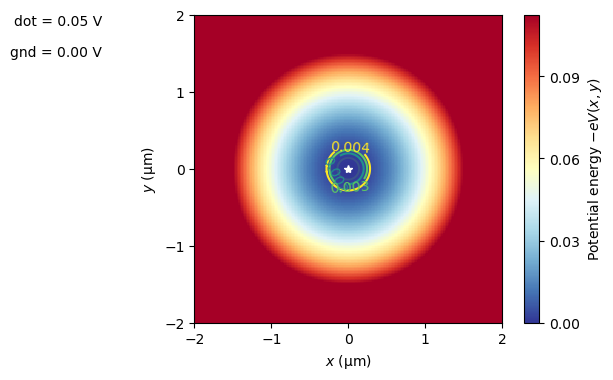

In [3]:
potential_dict = {"dot" : parabolic_confinement, 
                  "gnd" : guard_ring, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"dot" : 0.05, 
            "gnd" : 0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(4, 4))

# Minimization with `L-BFGS-B`

`quantum_electron` uses the scipy minimization routine with method `L-BFGS-B`. This is a very stable routine, but is not necessarily physical. To prevent getting stuck in local minima of the energy landscape, `trap_annealing_steps` can be set. More on this later.

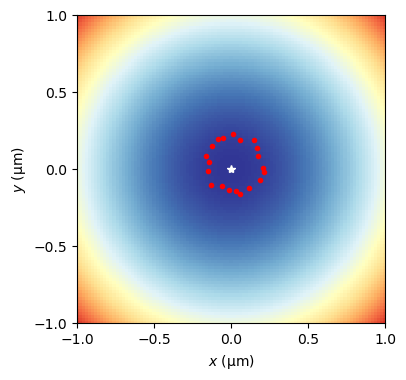

In [ ]:
n_electrons = 20

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[1.0]*20)

initial_condition = fm.generate_initial_condition(n_electrons=n_electrons) + 0.05e-6 * np.random.rand(2 * n_electrons)
init_x, init_y = r2xy(initial_condition)

res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=None)

fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)
# fm.plot_electron_positions(res, ax=ax)

plt.plot(init_x*1e6, init_y*1e6, '.r')

In [6]:
anim = fm.animate_convergence(fig, ax, frame_interval_ms=30)

In [7]:
fm.show_animation(anim)

Note how the electron positions jitter several times after they are released from their initial positions. This jittering is part of the annealing process, which tries to avoid getting stuck in local minima. In this case we provided 20 annealing steps with an effective temperature of 1 kelvin using the argument `trap_annealing_steps=[1.0]*20`. You can provide an arbitrary list of temperatures to taylor this process to your needs. 

# Physical gradient descent

The previous process tries to find the fastest way to the minimum energy configuration and, as such, it does not necessarily obey physics. Here we remedy this by explicitly writing the forces on each electron. To avoid any persistent oscillations, we must now add a damping `gamma` to the equations. Otherwise the system will never converge to the equilibrium positions. 

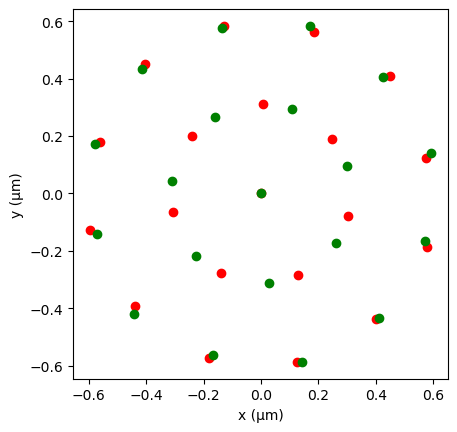

In [9]:
n_timesteps = 5000
dt = 1e-13 
gamma = -0.01 * me / dt # This is the damping parameter. 

r = np.zeros((2 * n_electrons, n_timesteps+2))

r[:, 0] = initial_condition
r[:, 1] = initial_condition

for k in range(2, n_timesteps+2):
    prefactor = 1 / (me / dt ** 2 - gamma / dt)
    F = - qe * fm.grad_total(r[:, k-1])
    r[:, k] = prefactor * (F - r[:, k-1] * (-2 * me / dt ** 2 + gamma / dt) - r[:, k-2] * me / dt ** 2)
    
rx, ry = r2xy(r[:, -1])
final_x, final_y = r2xy(res['x'])

# plt.plot(init_x*1e6, init_y*1e6, 'ob')
plt.plot(rx*1e6, ry*1e6, 'or')
plt.plot(final_x*1e6, final_y*1e6, 'og')
plt.xlabel(f"x ({chr(956)}m)")
plt.ylabel(f"y ({chr(956)}m)")
plt.gca().set_aspect('equal')

The equilibrium positions are indeed similar up to a rotation factor. Let us now visualize the convergence of this more physical method!

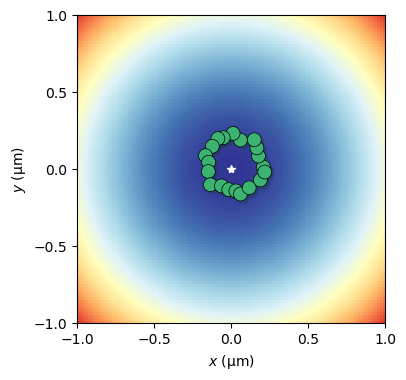

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)

rx, ry = r2xy(r[:, -1])
pts_data = ax.plot(rx*1e6, ry*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])

# Only things in the update function will get updated.
def update(frame):
    rx, ry = r2xy(r[:, frame])
    # Update the electron positions (green dots)
    pts_data[0].set_xdata(rx * 1e6)
    pts_data[0].set_ydata(ry * 1e6)

    return pts_data, 

# The interval is in milliseconds 
anim = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(2, n_timesteps+2, 25), interval=30, repeat=True)

The following animation shows a nicely damped oscillation. Try playing with the `gamma` parameter to transition from a damped system to underdamped system.

In [12]:
fm.show_animation(anim)

# Sample from the Maxwell-Boltzmann distribution

Here, we may also try to mimic the situation where electrons are in thermal equilibrium with a thermal bath. We pretend the electrons have a velocity that is sampled from the Maxwell-Boltzmann distribution. 

In [ ]:
class MaxBoltz2D(scipy.stats.rv_continuous):
    def _pdf(self, v, T):
        sigma = np.sqrt(kB * T / me)
        return v / sigma ** 2 * np.exp(- v ** 2 / (2 * sigma ** 2))
    
sample_v = MaxBoltz2D(a=0, b=4e4, name='velocity')

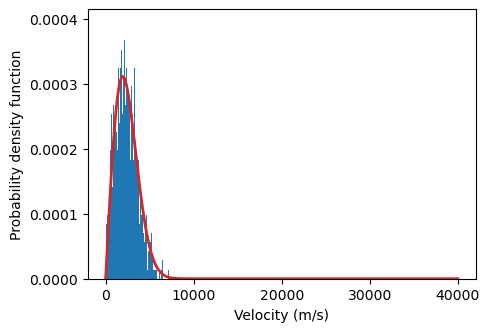

In [15]:
T_eff = 0.25 # Effective temperature
samples = sample_v.rvs(size=1000, T=T_eff)
v = np.linspace(0, 4e4, 10000)

fig = plt.figure(figsize=(5.,3.5))
plt.hist(samples, bins=100, density=True)
plt.plot(v, sample_v._pdf(v, T_eff), color='tab:red', lw=2)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Probability density function")
plt.locator_params(axis='both', nbins=5)

|████████████████████████████████████████| 20000/20000 [100%] in 19.9s (1007.25/s)                                       8501/20000 [43%] in 8s (~11s, 1004.6/s) 


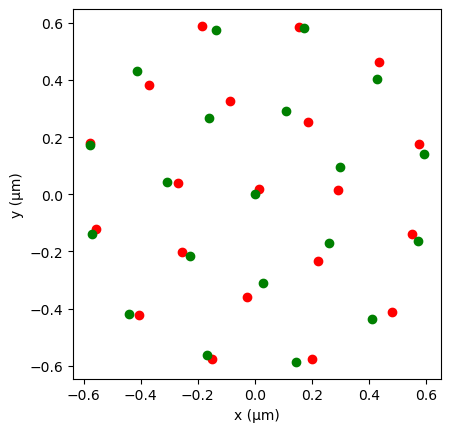

In [24]:
n_timesteps = 20000
dt = 1e-13
gamma = -0.01 * me / dt

# Try increasing the effective temperature to increase the magnitude of the kick for each electron 
T_eff = 0.1

r = np.zeros((2 * n_electrons, n_timesteps+2))

# Start with the best solution at T = 0
# perturbation = 0.1*np.random.rand(2 * n_electrons) * 1e-6
r[:, 0] = res['x'] #+ perturbation
r[:, 1] = res['x'] #+ perturbation

with alive_progress.alive_bar(n_timesteps, force_tty=True) as bar:
    for k in range(2, n_timesteps+2):
        prefactor = 1 / (me / dt ** 2 - gamma / dt)
        F = - qe * fm.grad_total(r[:, k-1])
        r[:, k] = prefactor * (F - r[:, k-1] * (-2 * me / dt ** 2 + gamma / dt) - r[:, k-2] * me / dt ** 2)
        
        # Every n-th iteration, give the electron a kick in an arbitrary direction with velocity equal to the Maxwell-Boltzmann distribution:
        if not (k%50):
            # Add some temperature
            velocities = sample_v.rvs(size=n_electrons, T=T_eff)
            thetas = np.random.uniform(low=0, high=2*np.pi, size=n_electrons)
            perturbation = np.zeros(2 * n_electrons)
            perturbation[::2] = velocities * np.cos(thetas) * dt
            perturbation[1::2] = velocities * np.sin(thetas) * dt
            
            # perturbation = random_sign(2 * n_electrons) * velocities * dt
            r[:, k] = r[:, k-2] + perturbation * 100
            r[:, k-1] = r[:, k-2] + perturbation * 100
            r[:, k-2] = r[:, k-2] + perturbation * 100
    
        bar()
    
rx, ry = r2xy(r[:, -1])
final_x, final_y = r2xy(res['x'])

# plt.plot(init_x*1e6, init_y*1e6, 'ob')
plt.plot(rx*1e6, ry*1e6, 'or')
plt.plot(final_x*1e6, final_y*1e6, 'og')
plt.xlabel(f"x ({chr(956)}m)")
plt.ylabel(f"y ({chr(956)}m)")
plt.gca().set_aspect('equal')

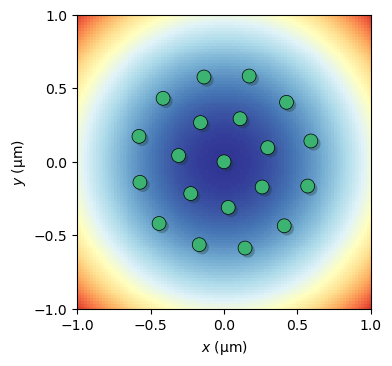

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=False)

rx, ry = r2xy(r[:, -1])
pts_data = ax.plot(rx*1e6, ry*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])

# Only things in the update function will get updated.
def update(frame):
    rx, ry = r2xy(r[:, frame])
    # Update the electron positions (green dots)
    pts_data[0].set_xdata(rx * 1e6)
    pts_data[0].set_ydata(ry * 1e6)

    return pts_data, 

fig.tight_layout()
# The interval is in milliseconds 
anim = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(2, n_timesteps+2, 25), interval=30, repeat=True)

In the animation below, you should observe significant jitter which is supposed to mimic the thermal motion.

In [ ]:
fm.show_animation(anim)

# Conclusion

In this notebook we've looked at ways to visualize convergence of the minimization procedure. There are various ways to improve and customize the convergence. We looked at one way to include random kicks with a magnitude derived from the Maxwell-Boltzmann distribution. However, if the connection to a thermal bath is desired, for example to compare simulations with experimental data taken at higher temperatures, we advise to use more rigorous Molecular Dynamics simulation packages, such as LAMPPS https://docs.lammps.org/Intro_overview.html, or HOOMD. 